<a href="https://colab.research.google.com/github/fid2445/Project-2/blob/main/7/20/22%20Project_2_Mike_Fiddler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Mike Fiddler 7/14/22
### Do People Prefer Shows or Movies (Project 2)

In [153]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector,make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn import set_config
set_config(display='diagram')

In [154]:
df = pd.read_excel('/content/drive/MyDrive/Netflix Project.xlsx')
df.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,48,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,113,"['crime', 'drama']",['US'],NaN,tt0075314,8.3,795222.0,27.612,8.2
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['comedy', 'fantasy']",['GB'],NaN,tt0071853,8.2,530877.0,18.216,7.8
3,tm70993,Life of Brian,MOVIE,"Brian Cohen is an average young Jewish man, bu...",1979,R,94,['comedy'],['GB'],NaN,tt0079470,8.0,392419.0,17.505,7.8
4,tm190788,The Exorcist,MOVIE,12-year-old Regan MacNeil begins to adapt an e...,1973,R,133,['horror'],['US'],NaN,tt0070047,8.1,391942.0,95.337,7.7


Data source https://www.kaggle.com/datasets/victorsoeiro/netflix-tv-shows-and-movies

This data set shows us all the different movies and shows available on the app Netflix.  We have imdb ratings, runtime, genre, release year.  
I am looking into this data set as i want to see if people are favoring shows instead of movies these days meaning this is a classification problem.

In [155]:
df.shape

(5806, 15)

In [156]:
df.dtypes.value_counts().cumsum()

object      8
float64    13
int64      15
dtype: int64

Here we can see we have 15 features and 5806 rows.

With almost 6000 rows I suspect there will alot of cleaning needed before any predictions can be made.  Just in the header i can see missing values that will need addressing.

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5806 entries, 0 to 5805
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    5806 non-null   object 
 1   title                 5805 non-null   object 
 2   type                  5806 non-null   object 
 3   description           5788 non-null   object 
 4   release_year          5806 non-null   int64  
 5   age_certification     3196 non-null   object 
 6   runtime               5806 non-null   int64  
 7   genres                5806 non-null   object 
 8   production_countries  5806 non-null   object 
 9   seasons               2047 non-null   float64
 10  imdb_id               5362 non-null   object 
 11  imdb_score            5283 non-null   float64
 12  imdb_votes            5267 non-null   float64
 13  tmdb_popularity       5712 non-null   float64
 14  tmdb_score            5488 non-null   float64
dtypes: float64(5), int64(

In [158]:
df.duplicated().sum()

0

In [159]:
df.isna().sum()

id                         0
title                      1
type                       0
description               18
release_year               0
age_certification       2610
runtime                    0
genres                     0
production_countries       0
seasons                 3759
imdb_id                  444
imdb_score               523
imdb_votes               539
tmdb_popularity           94
tmdb_score               318
dtype: int64

alot of missing values need addressing

were going to drop the columns release_year (not allowed to use time series), age_certificaion (the target audience does not effect our goal) and seasons (we dont care how long it ran for)

In [160]:
df.drop(columns='release_year',inplace=True)

In [161]:
df.drop(columns='age_certification',inplace=True)

In [162]:
df.drop(columns='seasons',inplace=True)
df.isna().sum()

id                        0
title                     1
type                      0
description              18
runtime                   0
genres                    0
production_countries      0
imdb_id                 444
imdb_score              523
imdb_votes              539
tmdb_popularity          94
tmdb_score              318
dtype: int64

were also going to drop the id, title, description, production_countries, and imdb_id columns. none of these have information that will help us 

In [163]:
df.drop(columns='id',inplace=True)
df.drop(columns='imdb_id',inplace=True)
df.drop(columns='title',inplace=True)
df.drop(columns='description',inplace=True)
df.drop(columns='production_countries',inplace=True)
df.isna().sum()

type                 0
runtime              0
genres               0
imdb_score         523
imdb_votes         539
tmdb_popularity     94
tmdb_score         318
dtype: int64

In [164]:
df_ml = df.copy() # we need a copy before any imputation to prevent data leakage

In [165]:
df.head()

,type,runtime,genres,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,SHOW,48,['documentation'],NaN,NaN,0.600,NaN
1,MOVIE,113,"['crime', 'drama']",8.3,795222.0,27.612,8.2
2,MOVIE,91,"['comedy', 'fantasy']",8.2,530877.0,18.216,7.8
3,MOVIE,94,['comedy'],8.0,392419.0,17.505,7.8
4,MOVIE,133,['horror'],8.1,391942.0,95.337,7.7


now im going to make sure our cat and num values are correct

In [166]:
df.describe().round(2)

,runtime,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
count,5806.00,5283.00,5267.00,5712.00,5488.00
mean,77.64,6.53,23407.19,22.53,6.82
std,39.47,1.16,87134.32,68.85,1.17
min,0.00,1.50,5.00,0.01,0.50
25%,44.00,5.80,521.00,3.16,6.10
50%,84.00,6.60,2279.00,7.48,6.90
75%,105.00,7.40,10144.00,17.78,7.50
max,251.00,9.60,2268288.00,1823.37,10.00


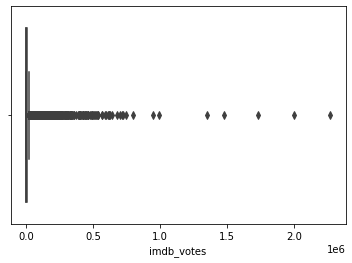

In [167]:
sns.boxplot(x='imdb_votes', data=df);

so here we can see we have alot of outliers in our IMDB_votes, exclusivly on the high side.  with this amount of outliers i may have to remove this column all together but im going to ask my TAs about it first

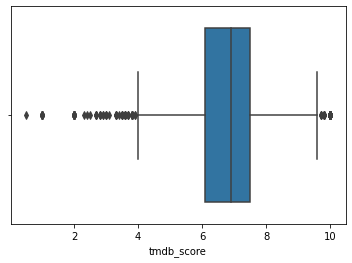

In [168]:
sns.boxplot(x='tmdb_score', data=df);

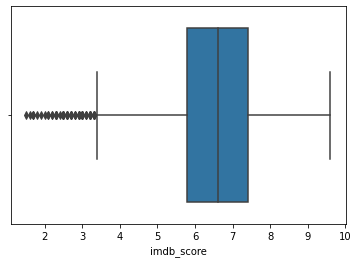

In [169]:
sns.boxplot(x='imdb_score', data=df);

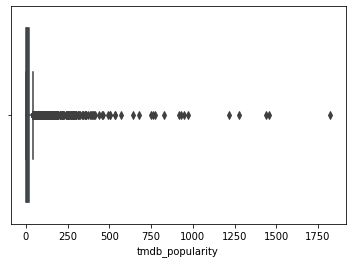

In [170]:
sns.boxplot(x='tmdb_popularity', data=df);

just as we did with imdb_score, we have a ton of outliers here, once again all on the high side.  also the same as imdb_score i may need to remove this column as the outliers will skew the data 

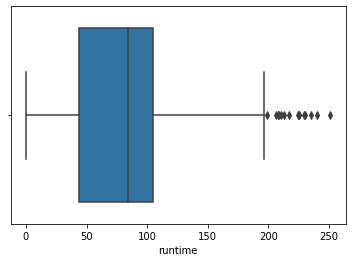

In [171]:
sns.boxplot(x='runtime', data=df);

this isnt that bad, we have a few outliers but we can see that most of our programming is in the 45-110 minute time.

In [172]:
df['type'].value_counts()

MOVIE    3759
SHOW     2047
Name: type, dtype: int64

In [173]:
df['genres'].value_counts()   #is there a way to boil these values down to a max of one or two categories? like comedy or drama but not both?

['comedy']                                            510
['drama']                                             350
['documentation']                                     320
['comedy', 'drama']                                   141
['drama', 'comedy']                                   128
                                                     ... 
['drama', 'family', 'comedy', 'music']                  1
['drama', 'thriller', 'western']                        1
['comedy', 'thriller', 'drama', 'action', 'crime']      1
['romance', 'drama', 'history', 'european']             1
['family', 'comedy', 'animation']                       1
Name: genres, Length: 1626, dtype: int64

In [174]:
df['imdb_score'].value_counts()

6.6    201
6.8    199
6.5    193
6.2    192
7.4    190
      ... 
2.0      1
1.9      1
2.4      1
1.6      1
1.8      1
Name: imdb_score, Length: 81, dtype: int64

In [175]:
df['imdb_score'].describe()

count    5283.000000
mean        6.533447
std         1.160932
min         1.500000
25%         5.800000
50%         6.600000
75%         7.400000
max         9.600000
Name: imdb_score, dtype: float64

that looks good

In [176]:
df['imdb_votes'].value_counts()

43.0        11
25.0        11
30.0         9
14.0         9
74.0         9
            ..
103.0        1
399.0        1
278223.0     1
28718.0      1
10418.0      1
Name: imdb_votes, Length: 3831, dtype: int64

In [177]:
df['imdb_votes'].describe()

count    5.267000e+03
mean     2.340719e+04
std      8.713432e+04
min      5.000000e+00
25%      5.210000e+02
50%      2.279000e+03
75%      1.014400e+04
max      2.268288e+06
Name: imdb_votes, dtype: float64

we may have to come back and delete this column but for now if a target has more votes that means more people liked it and that is a part of what we are trying to learn

In [178]:
df['tmdb_popularity'].value_counts()

1.400     66
0.600     57
1.960      8
2.744      7
0.840      7
          ..
70.563     1
7.434      1
33.558     1
60.496     1
0.979      1
Name: tmdb_popularity, Length: 4943, dtype: int64

In [179]:
df['tmdb_popularity'].describe()

count    5712.000000
mean       22.525660
std        68.849177
min         0.009442
25%         3.155250
50%         7.478000
75%        17.775750
max      1823.374000
Name: tmdb_popularity, dtype: float64

In [180]:
df['tmdb_score'].value_counts()

7.0    285
7.3    208
6.8    207
6.5    204
7.4    201
      ... 
2.3      1
3.1      1
0.5      1
3.4      1
2.5      1
Name: tmdb_score, Length: 78, dtype: int64

In [181]:
df['tmdb_score'].describe()

count    5488.000000
mean        6.818039
std         1.171560
min         0.500000
25%         6.100000
50%         6.900000
75%         7.500000
max        10.000000
Name: tmdb_score, dtype: float64

In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5806 entries, 0 to 5805
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   type             5806 non-null   object 
 1   runtime          5806 non-null   int64  
 2   genres           5806 non-null   object 
 3   imdb_score       5283 non-null   float64
 4   imdb_votes       5267 non-null   float64
 5   tmdb_popularity  5712 non-null   float64
 6   tmdb_score       5488 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 317.6+ KB


data types are correct, we have 4 columns missing data.  as i dont want to skew the data too much i am going to use the mean of each column to impute the missing data. 

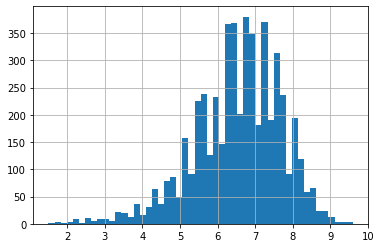

In [183]:
df['imdb_score'].hist(bins=50);

before we impute i wanted to get a visual of how our scores are allocated. we see most shows/movies score between a rating of 6 to 8.

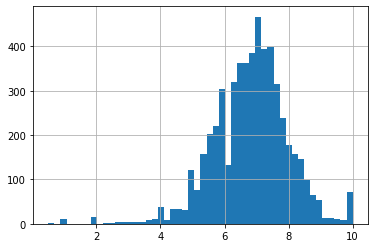

In [184]:
df['tmdb_score'].hist(bins=50);

the tmbd movie scores follow in a similar pattern.

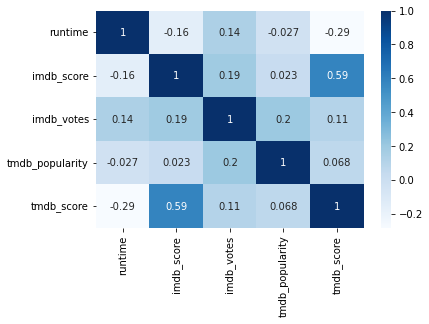

In [185]:
corr = df.corr()
sns.heatmap(corr, cmap = 'Blues', annot = True);

ok so we can see the moderate correlation between imdb and tmdb scores, nothing else correlates

In [186]:
imdb_score_mean = df['imdb_score'].mean()
df['imdb_score'].fillna(imdb_score_mean, inplace=True)
df['imdb_score'].isna().sum()

0

In [187]:
imdb_votes_median = df['imdb_votes'].median()
df['imdb_votes'].fillna(imdb_votes_median, inplace=True)
df['imdb_votes'].isna().sum()

0

In [188]:
tmdb_pop_median = df['tmdb_popularity'].median()
df['tmdb_popularity'].fillna(tmdb_pop_median, inplace=True)
df['tmdb_popularity'].isna().sum()

0

In [189]:
tmdb_score_mean = df['tmdb_score'].mean()
df['tmdb_score'].fillna(tmdb_score_mean, inplace=True)
df.isna().sum()

type               0
runtime            0
genres             0
imdb_score         0
imdb_votes         0
tmdb_popularity    0
tmdb_score         0
dtype: int64

perfect, no missing data

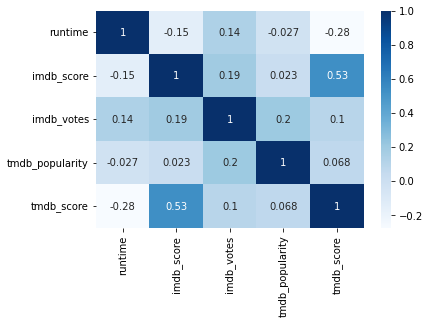

In [190]:
corr = df.corr()
sns.heatmap(corr, cmap = 'Blues', annot = True);

after imputing we notice that our correlation between imdb_score and tmdb_score has gone down by a few percentage points, shouldnt be a big deal. nothing else has changed. 

## ML prep

In [191]:
df_ml['type'].value_counts(normalize=True)

MOVIE    0.647434
SHOW     0.352566
Name: type, dtype: float64

not a well balanced set, we will have to keep this in mind as we analyize it.

In [192]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5806 entries, 0 to 5805
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   type             5806 non-null   object 
 1   runtime          5806 non-null   int64  
 2   genres           5806 non-null   object 
 3   imdb_score       5283 non-null   float64
 4   imdb_votes       5267 non-null   float64
 5   tmdb_popularity  5712 non-null   float64
 6   tmdb_score       5488 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 317.6+ KB


time to split, then setup selectors and pipelines, then we can impute 

In [193]:
#Validation split
X = df_ml.drop(columns=['type'])
y = df_ml['type']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [194]:
#making our ohe pipeline, selector(s) first
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')

as i did for EDA im going to use the mean of each column to impute our missing values. 

In [195]:
# Imputers
median_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

i had originally wanted to use mean to impute my data but with so many outliers skewed on the high side of both imdb_score and tmdb_popularity im going to use median so i dont skew my data any more

In [196]:
numb_pipe = make_pipeline(median_imputer, scaler)
numb_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [197]:
cat_pipe = make_pipeline(ohe)
cat_pipe

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

no missing cat data so we wont need to impute anything. im not sure if its a good practice to leave that part out completly to save space in the code or if we should put it in anyway. 

In [198]:
numb_tup = (numb_pipe, num_selector)
cat_tup = (cat_pipe, cat_selector)
preprocessor = make_column_transformer(numb_tup, cat_tup)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa287a8efd0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa287a8e650>)])

In [199]:
#fit on the train
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa287a8efd0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa287a8e650>)])

In [200]:
#transform and test
X_train_pro = preprocessor.transform(X_train)
X_test_pro = preprocessor.transform(X_test)
X_train_pro

array([[-1.61022176,  0.32876869, -0.24133331, ...,  0.        ,
         0.        ,  0.        ],
       [-1.33224388,  1.21837089, -0.06944034, ...,  0.        ,
         0.        ,  0.        ],
       [-0.39722735,  1.30733111,  0.31871125, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.79049635, -0.73875394, -0.15512751, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.66414277, -1.18355504, -0.24368971, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.57388858,  0.06188804, -0.20381135, ...,  0.        ,
         0.        ,  0.        ]])

In [201]:
np.isnan(X_train_pro).sum().sum()

0

In [202]:
np.isnan(X_test_pro).sum().sum()

0

we are not missing any data in our X_sets so we are ready for modeling